In [1]:
#Import necessary libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import MinMaxScaler

In [3]:
#load dataset
movies_df = pd.read_csv('resources/movies_metadata.csv')


In [4]:
# Convert release_date to datetime
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'])

# Drop irrelevant columns
movies_df.drop(['id', 'production_companies', 'production_countries', 'status'], axis=1, inplace=True)

# Fill missing values
movies_df['tagline'].fillna('', inplace=True)
movies_df['overview'].fillna('', inplace=True)

<b>Build a content-based recommendation system </b>

In [5]:
# Combine keywords and overview
movies_df['description'] = movies_df['overview'] + movies_df['tagline']

# Calculate TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df['description'])

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Function to get recommendations based on a given movie title
def content_based_recommendations(title, cosine_sim=cosine_sim):
    indices = pd.Series(movies_df.index, index=movies_df['title']).drop_duplicates()
    
    if title not in indices:
        return "Movie not found in the database."
    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    
    movie_indices = [i[0] for i in sim_scores]
    return movies_df['title'].iloc[movie_indices]


In [8]:
#Recommendation based on favorite movie(s):
favorite_movie = input("Enter your favorite movie: ")
recommendations = content_based_recommendations(favorite_movie)
print("Recommended movies based on your favorite movie:")
print(recommendations)

Enter your favorite movie:  Jumanji


Recommended movies based on your favorite movie:
16650          Table No. 21
22875                Pixels
29621          Snowed Under
31177                  Ludo
25977              The Mend
7543                Quintet
28574             Beta Test
13490        The Dark Angel
7986              Word Wars
26976    The Ouija Exorcism
Name: title, dtype: object


In [9]:
#Recommendation based on genre:
def genre_based_recommendations(genre):
    return movies_df[movies_df['genres'].str.contains(genre, na=False)].nlargest(10, 'popularity')['title']

genre = input("Enter the genre you'd like to explore: ")
recommendations = genre_based_recommendations(genre)
print("Recommended movies based on genre:")
print(recommendations)

Enter the genre you'd like to explore:  Action


Recommended movies based on genre:
24781                                        Wonder Woman
30939                                         Baby Driver
18693                                          Big Hero 6
20283                                            Deadpool
20284                      Guardians of the Galaxy Vol. 2
11707                                              Avatar
18612                                           John Wick
20285                          Captain America: Civil War
20280    Pirates of the Caribbean: Dead Men Tell No Tales
10204                                     The Dark Knight
Name: title, dtype: object


In [10]:
#Recommendation based on mood:
mood_genre_map = {
    'happy': ['Comedy', 'Romance', 'Animation'],
    'sad': ['Drama', 'War'],
    'bored': ['Adventure', 'Action', 'Thriller'],
}

def mood_based_recommendations(mood):
    genres = mood_genre_map[mood]
    recommendations = []
    for genre in genres:
        recommendations.extend(genre_based_recommendations(genre)[:3].tolist())
    return recommendations

mood = input("Enter your mood [happy, sad, bored]: ")
recommendations = mood_based_recommendations(mood)
print("Recommended movies based on mood:")
print(recommendations)

Enter your mood [happy, sad, bored]:  bored


Recommended movies based on mood:
['Minions', 'Wonder Woman', 'Big Hero 6', 'Wonder Woman', 'Baby Driver', 'Big Hero 6', 'John Wick', 'Gone Girl', 'The Hunger Games: Mockingjay - Part 1']


In [11]:
#Recommend cult-classics based on genre:
def cult_classic_recommendations(genre):
    low_budget = movies_df['budget'].quantile(0.25)
    high_rating = movies_df['vote_average'].quantile(0.75)

    cult_classics = movies_df[(movies_df['budget'] <= low_budget) &
                               (movies_df['vote_average'] >= high_rating) &
                               (movies_df['genres'].str.contains(genre, na=False))]
    return cult_classics.nlargest(10, 'vote_average')['title']

genre = input("Enter the genre for cult-classic recommendations: ")
recommendations = cult_classic_recommendations(genre)
print("Recommended cult-classic movies based on genre:")
print(recommendations)


Enter the genre for cult-classic recommendations:  Romance


Recommended cult-classic movies based on genre:
356         Girl in the Cadillac
9958     Chilly Scenes of Winter
16000    The Taming of the Shrew
16530          A Ticklish Affair
19504          The Walking Stick
20891             The Little Hut
21134            Vessel of Wrath
21205                        Pan
23768        The Kreutzer Sonata
28363          The Far Pavilions
Name: title, dtype: object


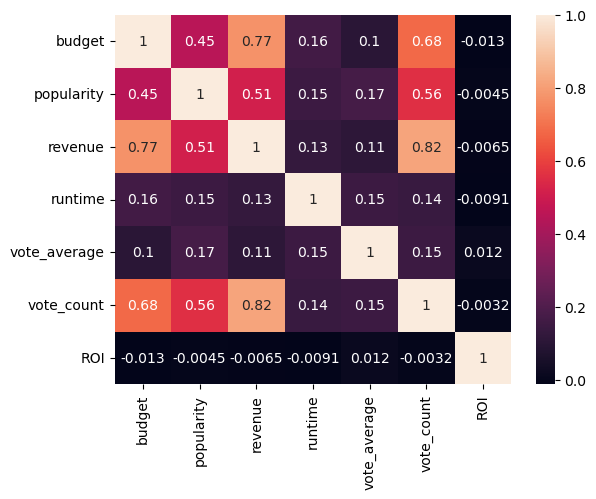

Factors correlating with the highest ROI:
ROI             1.000000
vote_average    0.011594
vote_count     -0.003239
popularity     -0.004472
revenue        -0.006512
runtime        -0.009053
budget         -0.013008
Name: ROI, dtype: float64


In [12]:
# Factors correlating with the highest ROI:
movies_df['ROI'] = movies_df['revenue'] / movies_df['budget']

correlation_matrix = movies_df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

# Check correlation of 'ROI' with other numerical features
roi_correlations = correlation_matrix['ROI'].sort_values(ascending=False)
print("Factors correlating with the highest ROI:")
print(roi_correlations)